<h1><b> Restaurant Rating Prediction</b></h1>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import matplotlib. pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
import keras
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D,Dropout
from keras.models import Model
from prettytable import PrettyTable



### Reading Data

In [3]:
df=pd.read_csv("/content/drive/My Drive/zomato.csv")

In [4]:
df.shape

(51717, 17)

In [5]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [6]:
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


In [7]:
df['rate'].describe()

count     43942
unique       64
top         NEW
freq       2208
Name: rate, dtype: object

<b> Checking for Duplicates in dataset</b>

In [8]:
df.duplicated().sum()

0

<b> Removing the features which don't have any impact on rating of the restaurant </b>

In [9]:
df=df.drop(['phone','address','url'],axis=1)

<b> Checking for percentage of NULL values for each features </b>

In [10]:
# https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

In [11]:
missing_value_df 

,percent_missing
name,0.000000
online_order,0.000000
book_table,0.000000
rate,15.033741
votes,0.000000
location,0.040606
rest_type,0.438927
dish_liked,54.291626
cuisines,0.087012
approx_cost(for two people),0.669026


Approach to fill the Null values - 
1. Rate and dish_liked - Model Based imputation
2. Location, cuisines, rest_type - Frequency based imputation
3. Approx_cost - Mean based imputation

<b>approx_cost NULL values</b>

In [12]:
df['approx_cost(for two people)']=df['approx_cost(for two people)'].replace(',','')
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].astype(str).str.replace(',', '')
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(lambda r: float(r))

Replacing NULL value with mean of approx_cost


In [13]:
df['approx_cost(for two people)']=df['approx_cost(for two people)'].fillna(df['approx_cost(for two people)'].mean())

#### rest_type NULL values 

In [14]:
df['rest_type'].isnull().values.sum()

227

In [15]:
df['rest_type'].value_counts()

Quick Bites                   19132
Casual Dining                 10330
Cafe                           3732
Delivery                       2604
Dessert Parlor                 2263
                              ...  
Bakery, Food Court                2
Food Court, Beverage Shop         2
Cafe, Food Court                  2
Quick Bites, Kiosk                1
Sweet Shop, Dessert Parlor        1
Name: rest_type, Length: 93, dtype: int64

In [16]:
# Replacing rest_type with top 2 occourings rest_type
df['rest_type']=df['rest_type'].fillna('Quick Bites, Casual Dining')

<b>Analyzing location column NULL values</b>

In [17]:
df['location'].value_counts()

BTM                      5124
HSR                      2523
Koramangala 5th Block    2504
JP Nagar                 2235
Whitefield               2144
                         ... 
West Bangalore              6
Yelahanka                   6
Jakkur                      3
Rajarajeshwari Nagar        2
Peenya                      1
Name: location, Length: 93, dtype: int64

In [18]:
df['location'].isnull().values.sum()

21

Hence there are only 21 datapoints whose location column is NULL, so lets assign their value as BTM because btm has the maximum no. of restaurants in Bangalore

In [19]:
df['location']=df['location'].fillna('BTM')

#### Cuisnies features

In [20]:
df['cuisines'].isnull().values.sum()

45

In [21]:
df['cuisines'].value_counts()

North Indian                                                  2913
North Indian, Chinese                                         2385
South Indian                                                  1828
Biryani                                                        918
Bakery, Desserts                                               911
                                                              ... 
North Indian, South Indian, Chinese, Desserts, Street Food       1
Cafe, Burger, Rolls, Beverages                                   1
Coffee, Street Food                                              1
North Indian, South Indian, Biryani, Fast Food                   1
Andhra, North Indian, Biryani, Seafood                           1
Name: cuisines, Length: 2723, dtype: int64

Replacing NULL values with top 3 cuisines


In [22]:
df['cuisines']=df['cuisines'].fillna('North Indian, chinese, South Indian')

## Replacing rate column missing values using Model based imputation

<p> Creating a dataframe having only non null rows</p>

In [23]:
vx=df.copy()
vx=df[(df['rate'].notnull()) & (df['rate']!='NEW') & (df['rate']!='-') ]
vx.shape

(41665, 14)

In [24]:
vx['rate'] = vx['rate'].astype(str).str.replace('/5', '')
from sklearn.model_selection import train_test_split
y = vx['rate']
X = vx.drop(['rate'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train['online_order'].values)
X_tr_order_ohe = vectorizer.transform(X_train['online_order'].values)
X_test_order_ohe = vectorizer.transform(X_test['online_order'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['book_table'].values)
X_tr_book_table = vectorizer.transform(X_train['book_table'].values)
X_test_book_table = vectorizer.transform(X_test['book_table'].values)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['location'].values)
X_tr_location = vectorizer.transform(X_train['location'].values)
X_test_location = vectorizer.transform(X_test['location'].values)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['rest_type'].values)
X_tr_rest_type = vectorizer.transform(X_train['rest_type'].values)
X_test_rest_type = vectorizer.transform(X_test['rest_type'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['cuisines'].values)
X_tr_cuisines	 = vectorizer.transform(X_train['cuisines'].values)
X_test_cuisines	 = vectorizer.transform(X_test['cuisines'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['listed_in(type)'].values)
X_tr_listed_in_t = vectorizer.transform(X_train['listed_in(type)'].values)
X_test_listed_in_t = vectorizer.transform(X_test['listed_in(type)'].values)

vectorizer = CountVectorizer()
vectorizer.fit(df['listed_in(city)'].values)
X_tr_listed_in_c = vectorizer.transform(X_train['listed_in(city)'].values)
X_test_listed_in_c = vectorizer.transform(X_test['listed_in(city)'].values)

from sklearn.preprocessing import Normalizer
cost_scalar = Normalizer()
cost_scalar.fit(X_train['approx_cost(for two people)'].values.reshape(-1,1))
cost_standardized_train = cost_scalar.transform(X_train['approx_cost(for two people)'].values.reshape(-1, 1))
cost_standardized_test = cost_scalar.transform(X_test['approx_cost(for two people)'].values.reshape(-1, 1))

In [26]:
from scipy.sparse import hstack
X_tr = hstack((X_tr_order_ohe,X_tr_book_table,X_tr_location,X_tr_rest_type,X_tr_cuisines,X_tr_listed_in_t,X_tr_listed_in_c,cost_standardized_train)).tocsr()
X_test = hstack((X_test_order_ohe,X_test_book_table,X_test_location,X_test_rest_type,X_test_cuisines,X_test_listed_in_t,X_test_listed_in_c,cost_standardized_test)).tocsr()


In [27]:
from sklearn.linear_model import LinearRegression
lm= LinearRegression().fit(X_tr,y_train)

Now we will create a dataframe that contains all the rows having missing values of rate

In [28]:
missing_values=df[(df['rate'].isnull()) | (df['rate']=='NEW') | (df['rate']=='-')]

In [29]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['online_order'].values)
X_order_ohe_missing_values = vectorizer.transform(missing_values['online_order'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['book_table'].values)
X_book_table_missing_values = vectorizer.transform(missing_values['book_table'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['location'].values)
X_location_missing_values = vectorizer.transform(missing_values['location'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['rest_type'].values)
X_rest_type_missing_values = vectorizer.transform(missing_values['rest_type'].values)



vectorizer = CountVectorizer()
vectorizer.fit(X_train['cuisines'].values)
X_cuisines_missing_values = vectorizer.transform(missing_values['cuisines'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['listed_in(type)'].values)
X_listed_in_t_missing_values = vectorizer.transform(missing_values['listed_in(type)'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['listed_in(city)'].values)
X_listed_in_c_missing_values = vectorizer.transform(missing_values['listed_in(city)'].values)


cost_scalar = Normalizer()
cost_scalar.fit(X_train['approx_cost(for two people)'].values.reshape(-1,1))
cost_standardized_train_missing_values = cost_scalar.transform(missing_values['approx_cost(for two people)'].values.reshape(-1, 1))

In [30]:
X_missing_values = hstack((X_order_ohe_missing_values,X_book_table_missing_values,X_location_missing_values,X_rest_type_missing_values,X_cuisines_missing_values,X_listed_in_t_missing_values,X_listed_in_c_missing_values,cost_standardized_train_missing_values)).tocsr()


In [31]:
lm.predict(X_missing_values)

array([3.47141183, 3.47916387, 3.44998216, ..., 3.60888675, 3.60888675,
       3.60888675])

In [32]:
y=lm.predict(X_missing_values)

In [33]:
missing_values=missing_values.drop(['rate'],axis=1)
missing_values['rate']=y

In [34]:
df2=pd.concat([vx,missing_values], axis=0)

In [35]:
df2.isna().any()

name                           False
online_order                   False
book_table                     False
rate                           False
votes                          False
location                       False
rest_type                      False
dish_liked                      True
cuisines                       False
approx_cost(for two people)    False
reviews_list                   False
menu_item                      False
listed_in(type)                False
listed_in(city)                False
dtype: bool

Now all the missing values of rate column is replaced using model predicted values

## Model Based imputation for dish_liked

In [36]:
df_no_null = df2[df2['dish_liked'].notnull()]

In [37]:
df_with_null=df2[df2['dish_liked'].isnull()]

In [38]:
y=df_no_null['dish_liked']
X=df_no_null.drop(['dish_liked'],axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train['online_order'].values)
X_tr_order_ohe = vectorizer.transform(X_train['online_order'].values)
X_test_order_ohe = vectorizer.transform(X_test['online_order'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['book_table'].values)
X_tr_book_table = vectorizer.transform(X_train['book_table'].values)
X_test_book_table = vectorizer.transform(X_test['book_table'].values)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['location'].values)
X_tr_location = vectorizer.transform(X_train['location'].values)
X_test_location = vectorizer.transform(X_test['location'].values)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['rest_type'].values)
X_tr_rest_type = vectorizer.transform(X_train['rest_type'].values)
X_test_rest_type = vectorizer.transform(X_test['rest_type'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['cuisines'].values)
X_tr_cuisines	 = vectorizer.transform(X_train['cuisines'].values)
X_test_cuisines	 = vectorizer.transform(X_test['cuisines'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['listed_in(type)'].values)
X_tr_listed_in_t = vectorizer.transform(X_train['listed_in(type)'].values)
X_test_listed_in_t = vectorizer.transform(X_test['listed_in(type)'].values)

vectorizer = CountVectorizer()
vectorizer.fit(df['listed_in(city)'].values)
X_tr_listed_in_c = vectorizer.transform(X_train['listed_in(city)'].values)
X_test_listed_in_c = vectorizer.transform(X_test['listed_in(city)'].values)

from sklearn.preprocessing import Normalizer
cost_scalar = Normalizer()
cost_scalar.fit(X_train['approx_cost(for two people)'].values.reshape(-1,1))
cost_standardized_train = cost_scalar.transform(X_train['approx_cost(for two people)'].values.reshape(-1, 1))
cost_standardized_test = cost_scalar.transform(X_test['approx_cost(for two people)'].values.reshape(-1, 1))

from sklearn.preprocessing import Normalizer
rate_scalar = Normalizer()
rate_scalar.fit(X_train['rate'].values.reshape(-1,1))
rate_standardized_train = rate_scalar.transform(X_train['rate'].values.reshape(-1, 1))
rate_standardized_test = rate_scalar.transform(X_test['rate'].values.reshape(-1, 1))

In [41]:
from scipy.sparse import hstack
X_tr = hstack((X_tr_order_ohe,X_tr_book_table,X_tr_location,X_tr_rest_type,X_tr_cuisines,X_tr_listed_in_t,X_tr_listed_in_c,cost_standardized_train,rate_standardized_train)).tocsr()
X_test = hstack((X_test_order_ohe,X_test_book_table,X_test_location,X_test_rest_type,X_test_cuisines,X_test_listed_in_t,X_test_listed_in_c,cost_standardized_test,rate_standardized_test)).tocsr()


In [42]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(X_tr, y_train)
#predictions = classifier.predict(x_test_multilabel)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l1',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=-1)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train['online_order'].values)
X_tr_order_ohe = vectorizer.transform(df_with_null['online_order'].values)
# X_test_order_ohe = vectorizer.transform(X_test['online_order'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['book_table'].values)
X_tr_book_table = vectorizer.transform(df_with_null['book_table'].values)
# X_test_book_table = vectorizer.transform(X_test['book_table'].values)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['location'].values)
X_tr_location = vectorizer.transform(df_with_null['location'].values)
# X_test_location = vectorizer.transform(X_test['location'].values)

vectorizer = CountVectorizer()
vectorizer.fit(X_train['rest_type'].values)
X_tr_rest_type = vectorizer.transform(df_with_null['rest_type'].values)
# X_test_rest_type = vectorizer.transform(X_test['rest_type'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['cuisines'].values)
X_tr_cuisines	 = vectorizer.transform(df_with_null['cuisines'].values)
# X_test_cuisines	 = vectorizer.transform(X_test['cuisines'].values)


vectorizer = CountVectorizer()
vectorizer.fit(X_train['listed_in(type)'].values)
X_tr_listed_in_t = vectorizer.transform(df_with_null['listed_in(type)'].values)
# X_test_listed_in_t = vectorizer.transform(X_test['listed_in(type)'].values)

vectorizer = CountVectorizer()
vectorizer.fit(df['listed_in(city)'].values)
X_tr_listed_in_c = vectorizer.transform(df_with_null['listed_in(city)'].values)
# X_test_listed_in_c = vectorizer.transform(X_test['listed_in(city)'].values)

from sklearn.preprocessing import Normalizer
cost_scalar = Normalizer()
cost_scalar.fit(X_train['approx_cost(for two people)'].values.reshape(-1,1))
cost_standardized_train = cost_scalar.transform(df_with_null['approx_cost(for two people)'].values.reshape(-1, 1))
# cost_standardized_test = cost_scalar.transform(X_test['approx_cost(for two people)'].values.reshape(-1, 1))

from sklearn.preprocessing import Normalizer
rate_scalar = Normalizer()
rate_scalar.fit(X_train['rate'].values.reshape(-1,1))
rate_standardized_train = rate_scalar.transform(df_with_null['rate'].values.reshape(-1, 1))
# rate_standardized_test = rate_scalar.transform(X_test['rate'].values.reshape(-1, 1))

In [44]:
X_tr = hstack((X_tr_order_ohe,X_tr_book_table,X_tr_location,X_tr_rest_type,X_tr_cuisines,X_tr_listed_in_t,X_tr_listed_in_c,cost_standardized_train,rate_standardized_train)).tocsr()

In [45]:
y=classifier.predict(X_tr)
df_with_null=df_with_null.drop(['dish_liked'],axis=1)
df_with_null['dish_liked']=y

In [46]:
df=pd.concat([df_with_null,df_no_null], axis=0)

In [47]:
df.head(2)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),dish_liked
6,Rosewood International Hotel - Bar & Restaurant,No,No,3.6,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,"Kadhai Paneer, Ghee Rice, Chicken Grill, Shawa..."
19,360 Atoms Restaurant And Cafe,Yes,No,3.1,13,Banashankari,Cafe,"Cafe, Chinese, Continental, Italian",400.0,"[('Rated 5.0', 'RATED\n Friendly staffs , nic...",[],Cafes,Banashankari,Friendly Staff


In [48]:
df.isna().any()

name                           False
online_order                   False
book_table                     False
rate                           False
votes                          False
location                       False
rest_type                      False
cuisines                       False
approx_cost(for two people)    False
reviews_list                   False
menu_item                      False
listed_in(type)                False
listed_in(city)                False
dish_liked                     False
dtype: bool

#### From the above table, we can see that all the null values are replaced 

In [49]:
df['rate']=df['rate'].apply(lambda r: float(r))

In [50]:
decimals = 1
df['rate'] = df['rate'].apply(lambda x: round(x, decimals))

# Exploratory Data Analysis

## Univariate Analysis

###### Analysis on location

In [51]:
df['listed_in(city)'].value_counts()

BTM                      3279
Koramangala 7th Block    2938
Koramangala 5th Block    2836
Koramangala 4th Block    2779
Koramangala 6th Block    2623
Jayanagar                2371
JP Nagar                 2096
Indiranagar              1860
Church Street            1827
MG Road                  1811
Brigade Road             1769
Lavelle Road             1744
HSR                      1741
Marathahalli             1659
Whitefield               1620
Residency Road           1620
Bannerghatta Road        1617
Brookefield              1518
Old Airport Road         1425
Kammanahalli             1329
Kalyan Nagar             1309
Basavanagudi             1266
Sarjapur Road            1261
Electronic City          1229
Bellandur                1227
Frazer Town              1185
Malleshwaram             1096
Rajajinagar              1079
Banashankari              863
New BEL Road              740
Name: listed_in(city), dtype: int64

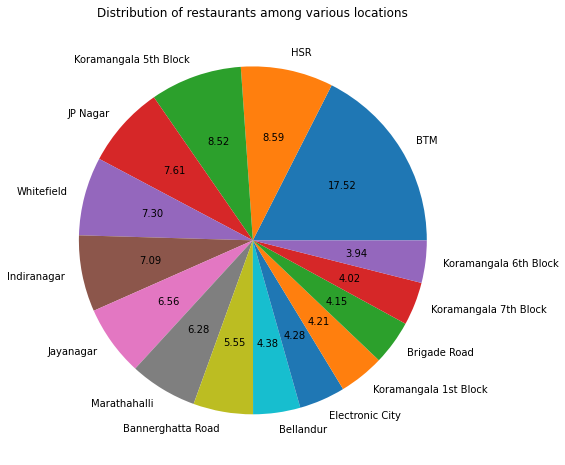

In [52]:
import matplotlib. pyplot as plt
plt.figure(figsize=(10,8))
x = df.location.value_counts()[:15]
y = df['location'].value_counts()[:15].index
plt.pie(x, labels=y, autopct='%.2f')
plt.title('Distribution of restaurants among various locations')
plt.show()

Text(0, 0.5, 'Number of Restaurant')

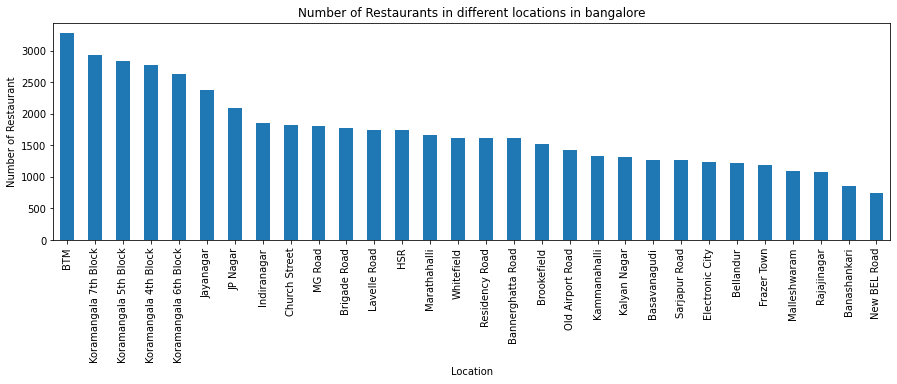

In [53]:
plt.figure(figsize=(15,4))
k =df['listed_in(city)'].value_counts()
k.plot(kind='bar')
plt.title('Number of Restaurants in different locations in bangalore')
plt.xlabel('Location')
plt.ylabel('Number of Restaurant')



<b>Conclusion</b>- There is a variation in restaurants as per the locations. BTM has the highest number of the restaurants in Bangalore that 3108 restarants. New BEL Road contains the least number of resturants followed by banashankari. Btm has 17.24% of the total restaurants in bangalore

###### Analysis on online order

In [54]:
df.online_order.value_counts()

Yes    30444
No     21273
Name: online_order, dtype: int64

Text(0, 0.5, 'counts')

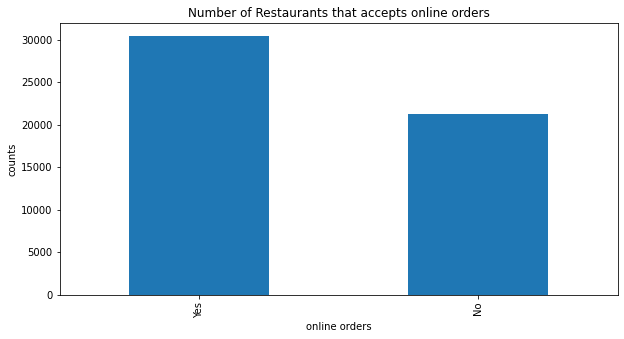

In [55]:
plt.figure(figsize=(10,5))
k =df['online_order'].value_counts()
k.plot(kind='bar')
plt.title('Number of Restaurants that accepts online orders')
plt.xlabel('online orders')
plt.ylabel('counts')

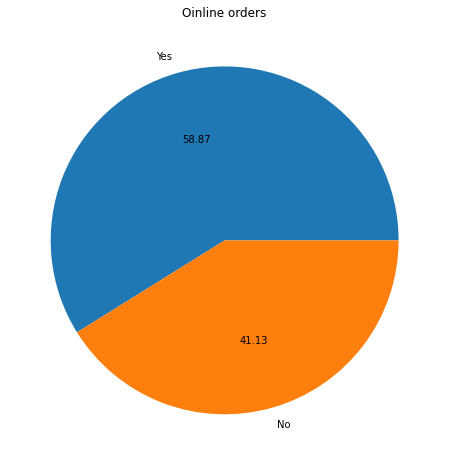

In [56]:
import matplotlib. pyplot as plt
plt.figure(figsize=(10,8))
x = df.online_order.value_counts()[:15]
y = df['online_order'].value_counts()[:15].index
plt.pie(x, labels=y, autopct='%.2f')
plt.title('Oinline orders')
plt.show()

<b>Conclusion</b>- Number of restaurants that allows online order are more than those restaurants who don't allows online order. There are 29342 restaurants in bangalore which are accpeting the online orders and 20098 restaurants which don't accepts the online order. There are 59.65% of restaurants that allows online ordering

###### Analysis on ratings 

In [57]:
df['rate'].value_counts()

3.5    5474
3.6    5135
3.7    4821
3.4    4711
3.8    4367
3.9    4180
3.3    3438
4.0    3321
4.1    2984
4.2    2198
3.2    2079
4.3    1707
3.1    1613
4.4    1147
3.0    1036
2.9     802
4.5     656
2.8     600
2.7     307
4.6     302
2.6     260
4.7     170
2.5     101
2.4      70
4.8      66
4.9      55
2.3      51
2.2      26
2.1      24
2.0      11
1.8       5
Name: rate, dtype: int64

Text(0, 0.5, 'No of Restaurants')

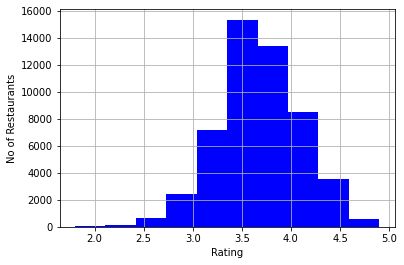

In [58]:
df['rate'] = df['rate'].apply(lambda r: float(r)) 
df['rate'].hist(color='blue')
plt.xlabel('Rating')
plt.ylabel('No of Restaurants')

In [59]:
print(df['rate'].min())
print(df['rate'].max())
print(df['rate'].mean())

1.8
4.9
3.6652106657383716


<b>Conclusion-</b> Majority of restaurants has ratings between 3.6 to 3.9. 15% of the restaurnts have an approx rating of 3.7 . Minimum rating for the restaurants is 1.8 . There is not even a single restaurant in bangalore where rating is equal to 5.

###### How many stores are there for each restaurants

In [60]:
df['name'].value_counts()

Cafe Coffee Day                           96
Onesta                                    85
Just Bake                                 73
Empire Restaurant                         71
Five Star Chicken                         70
                                          ..
Pepperwood 2                               1
Madurai Idli Dosa Shop                     1
Hotel New Grand                            1
S-Cafe                                     1
Republic Of Noodles - Lemon Tree Hotel     1
Name: name, Length: 8792, dtype: int64

In [61]:
df['name'].value_counts()

Cafe Coffee Day                           96
Onesta                                    85
Just Bake                                 73
Empire Restaurant                         71
Five Star Chicken                         70
                                          ..
Pepperwood 2                               1
Madurai Idli Dosa Shop                     1
Hotel New Grand                            1
S-Cafe                                     1
Republic Of Noodles - Lemon Tree Hotel     1
Name: name, Length: 8792, dtype: int64

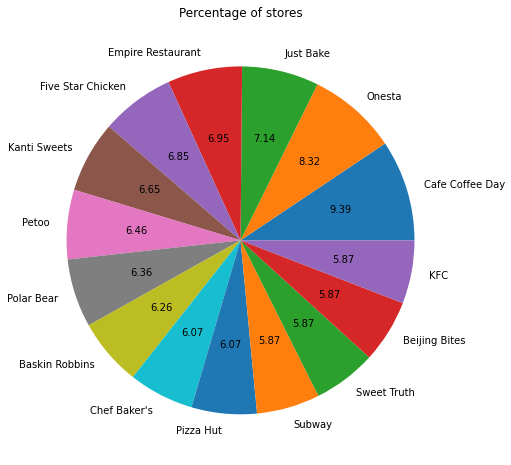

In [62]:
import matplotlib. pyplot as plt
plt.figure(figsize=(10,8))
x = df.name.value_counts()[:15]
y = df['name'].value_counts()[:15].index
plt.pie(x, labels=y, autopct='%.2f')
plt.title('Percentage of stores')
plt.show()

Text(0.5, 1.0, 'Number of stores for each restautant')

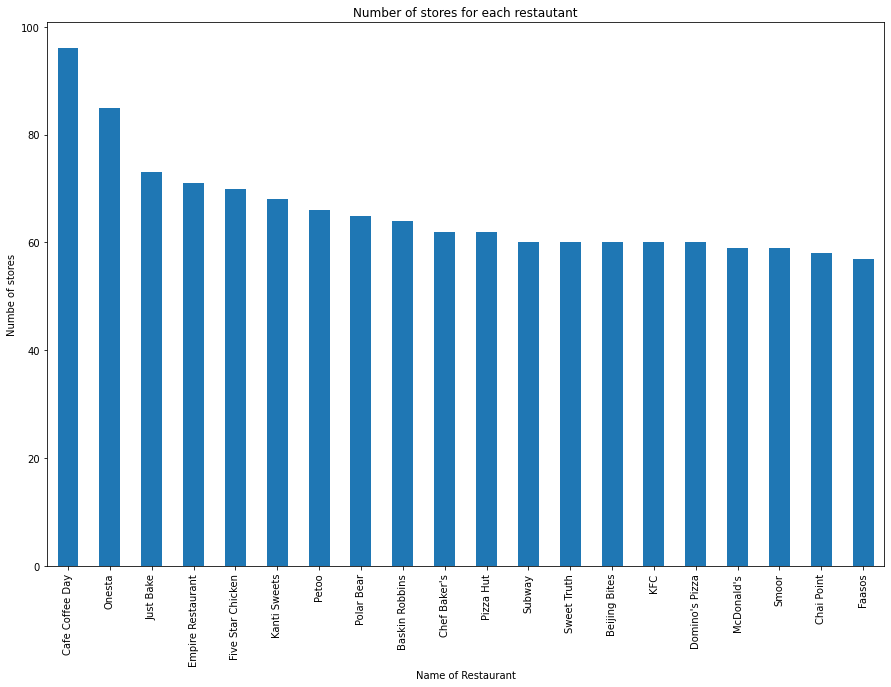

In [63]:
plt.figure(figsize = (15,10))
k = df.name.value_counts()[:20]
k.plot(kind = 'bar')
plt.xlabel("Name of Restaurant")
plt.ylabel("Numbe of stores")
plt.title("Number of stores for each restautant")

<b>Conclusion-</b> There is a variation in the number of stores in bangalore. CCD has maximum number of stores in bangalore followed by onesta and just bake. There are various restaurants that are having only 1 stores such as SV Juice Corner Tiffun, Brown box etc. The total no. of stores of CCD comprosed of 9.26 % of the entire stores present in bangalore 

##### Restaurants allows booking of tables

In [64]:
df['book_table'].value_counts()

No     45268
Yes     6449
Name: book_table, dtype: int64

Text(0.5, 0, 'Booking table')

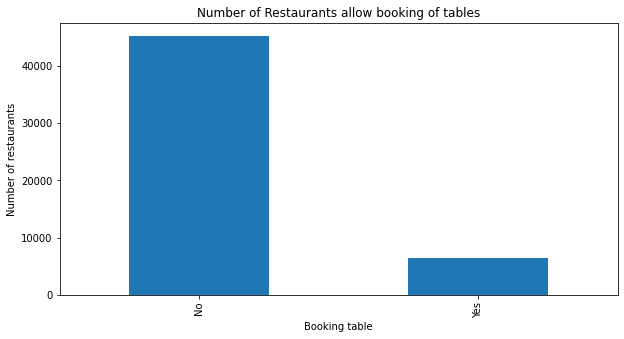

In [65]:
plt.figure(figsize=(10,5))
k =df['book_table'].value_counts()
k.plot(kind='bar')
plt.title('Number of Restaurants allow booking of tables')
plt.ylabel('Number of restaurants')
plt.xlabel('Booking table')

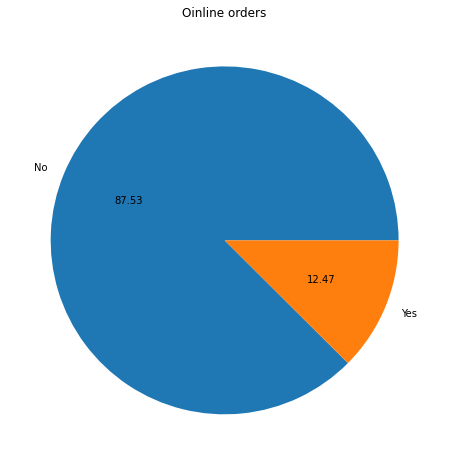

In [66]:
import matplotlib. pyplot as plt
plt.figure(figsize=(10,8))
x = df.book_table.value_counts()
y = df['book_table'].value_counts().index
plt.pie(x, labels=y, autopct='%.2f')
plt.title('Oinline orders')
plt.show()

<b>Conclusion</b>- There are 43120 restaurants that are accepting the booking of table and 6320 restarants that are not accepting the booking of table. Majority of restaurants may be street food type restaurant as it is not allowing booking of table. 87.22% of the restaurants are not allowing the booking of tables

#### Types of cuisines sold by most of the restaurants

Text(0, 0.5, 'Number of restaurants where this cuisine is available')

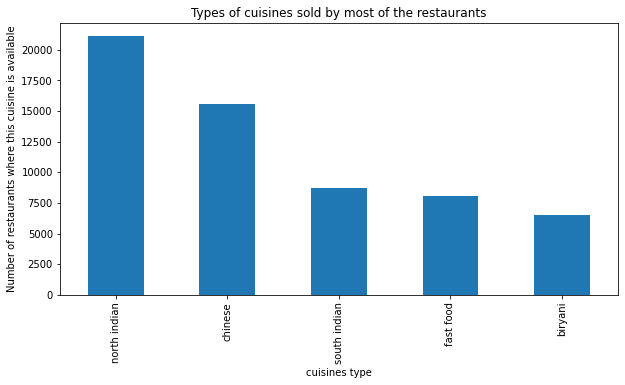

In [67]:
total=[]
k = df[df['cuisines'].notnull()]
k['cuisines'] = k['cuisines'].apply(lambda x:x.lower().strip())
for i in k['cuisines']:
    for j in i.split(','):
        j = j.strip()
        total.append(j)
plt.figure(figsize=(10,5)) 
a=pd.Series(total).value_counts()[:5]
a.plot(kind='bar')
plt.title('Types of cuisines sold by most of the restaurants')
plt.xlabel('cuisines type')
plt.ylabel('Number of restaurants where this cuisine is available')

<b>Conclusion</b> - North indian and chinese are the two most sold cusines in bangalore. Number of restaurants where north indian cuisine is available is close to 20,000 and number of restaurants where chinese food is available is close to 14,000.

#### Items liked by peoples in Bangalore

In [68]:
df['dish_liked'].nunique()

5271

Text(0, 0.5, 'Count')

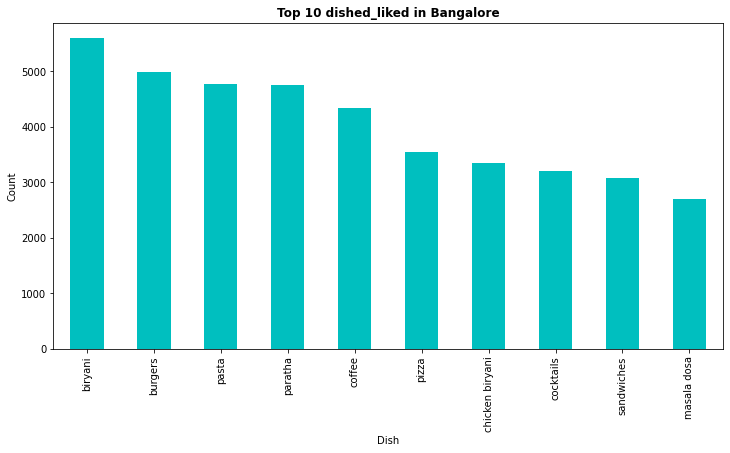

In [69]:
dishes_data = df[df.dish_liked.notnull()]
dishes_data.dish_liked = dishes_data.dish_liked.apply(lambda x:x.lower().strip())
dish_count = []
for i in dishes_data.dish_liked:
    for t in i.split(','):
        t = t.strip() # remove the white spaces to get accurate results
        dish_count.append(t)
plt.figure(figsize=(12,6)) 
pd.Series(dish_count).value_counts()[0:10].plot(kind='bar',color= 'c')
plt.title('Top 10 dished_liked in Bangalore',weight='bold')
plt.xlabel('Dish')
plt.ylabel('Count')

<b>Conclusion</b>- Biryani is the most liked dish by the peoples of bangalore. There are around 12000 restaunts where biryani is one of the mpst famous recipe. Chicken is the second most famous dish liked in bangalore

###### Analysis on cost of dining

In [70]:
df['approx_cost(for two people)']

6        800.0
19       400.0
22       900.0
24       300.0
25       600.0
         ...  
50032    250.0
50050    200.0
50135    650.0
50571    500.0
51386    500.0
Name: approx_cost(for two people), Length: 51717, dtype: float64

In [71]:
df['approx_cost(for two people)'].max()

6000.0

[7.36798345e-01 1.90285593e-01 5.24779086e-02 1.18336330e-02
 7.07697662e-03 7.73440068e-04 6.57424058e-04 3.86720034e-05
 1.93360017e-05 3.86720034e-05]
[  40.  636. 1232. 1828. 2424. 3020. 3616. 4212. 4808. 5404. 6000.]


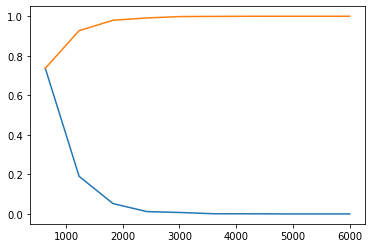

In [72]:
counts, bin_edges = np.histogram(df['approx_cost(for two people)'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)

#compute CDF
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:], cdf)

Text(0, 0.5, 'No of Restaurants')

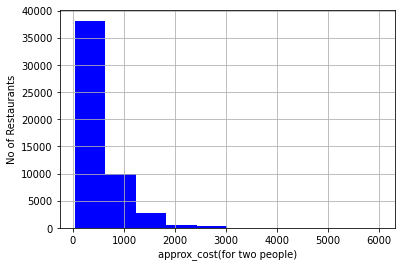

In [73]:
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(lambda r: float(r))
import matplotlib.pyplot as plt
df['approx_cost(for two people)'].hist(color="blue")
plt.xlabel('approx_cost(for two people)')
plt.ylabel('No of Restaurants')

In [74]:
df['approx_cost(for two people)'].mean()

555.4315664479955

<b>Conclusion</b>- Majority of restaurants in bangalore has average cost for 2 person is 561. The minimum cost for the dining is 40 and maximum cost is 6000. It concludes that there are all sorts of food at different prices are available in bangalore

<b> Votes</b>

Text(0, 0.5, 'No of Restaurants')

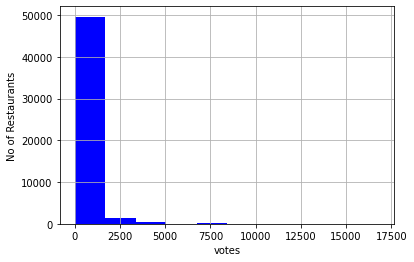

In [75]:
import matplotlib.pyplot as plt
df['votes'].hist(color="blue")
plt.xlabel('votes')
plt.ylabel('No of Restaurants')

[9.58794980e-01 2.80372025e-02 8.75920877e-03 1.19883211e-03
 1.93360017e-03 5.41408048e-04 2.51368022e-04 3.86720034e-05
 3.28712029e-04 1.16016010e-04]
[    0.   1683.2  3366.4  5049.6  6732.8  8416.  10099.2 11782.4 13465.6
 15148.8 16832. ]


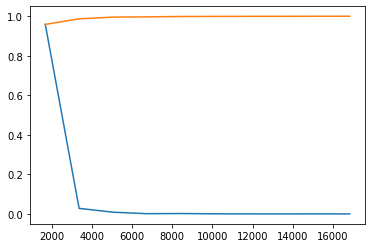

In [76]:
counts, bin_edges = np.histogram(df['votes'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))
print(pdf);
print(bin_edges)

#compute CDF
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:], cdf)

In [77]:
print(df['votes'].mean())
print(df['votes'].min())
print(df['votes'].max())

283.69752692538236
0
16832


<b>Conclusion</b> The restaurants in Bangalore has an average vote of 296.76 . Minimum vote for the restaurant is 0 and the maaximum votes are 16832. Very few restaurants in bangalore has no. of votes greater than 1700

#### Rating of restaurants vs online_order

In [78]:
df['rate']

6        3.6
19       3.1
22       3.6
24       3.7
25       3.2
        ... 
50032    3.5
50050    3.5
50135    3.5
50571    3.5
51386    3.5
Name: rate, Length: 51717, dtype: float64

Text(0.5, 1.0, 'rating of restaurant vs oline order')

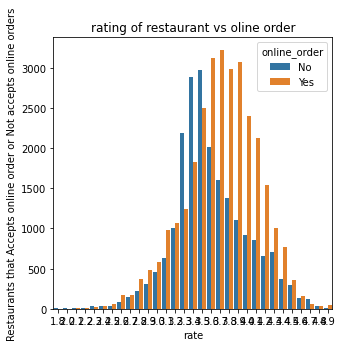

In [79]:
import seaborn as sns
plt.figure(figsize = (5,5))
sns.countplot(x=df['rate'], hue = df['online_order'])
plt.ylabel("Restaurants that Accepts online order or Not accepts online orders")
plt.xlabel('rate')
plt.title("rating of restaurant vs oline order")

<b>Conclusion</b> - Only for those restaurants whose rating is 3.7, the number of restaurants accepting online order is more than the restaurants who don't accepts the online order. For all the restaurants (whose rating is other than 3.7), there are mpre no. of restaurants that accepts online order rather than the restaurants who don't accepts the online order.

In [80]:
df['rate'].mean()

3.6652106657383716

Text(0.5, 1.0, 'rating of restaurant vs oline order')

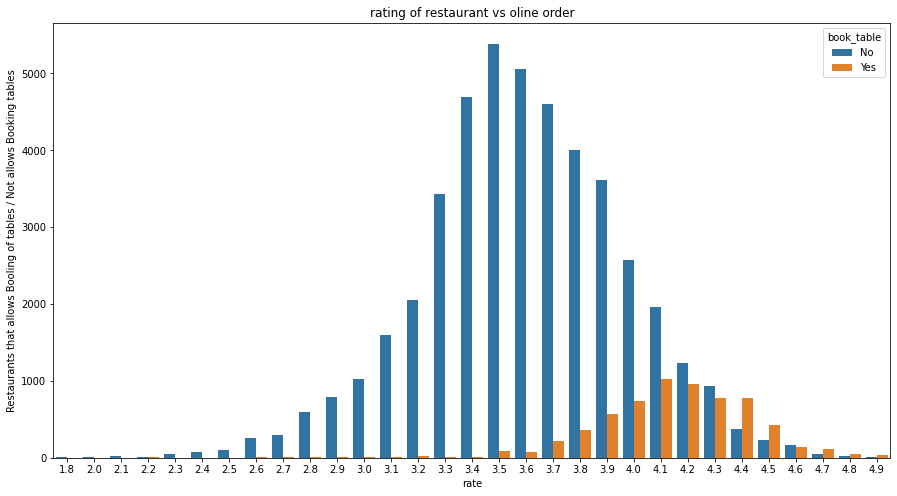

In [81]:
import seaborn as sns
plt.figure(figsize = (15,8))
sns.countplot(x=df['rate'], hue = df['book_table'])
plt.ylabel("Restaurants that allows Booling of tables / Not allows Booking tables")
plt.xlabel('rate')
plt.title("rating of restaurant vs oline order")

<b>Coclusion</b>- The maximum no. restaurants that allows table booking has an average rating of 4.2 . The maximum number of restaurants, which dont allows table booking has an average rating of 3.7 . Irrespective of ratings, the number of restaurants that allows booking of tables are less than the restaurants which don;t allows that.

##### Type of restaurant

In [82]:
df['listed_in(type)'].value_counts()

Delivery              25942
Dine-out              17779
Desserts               3593
Cafes                  1723
Drinks & nightlife     1101
Buffet                  882
Pubs and bars           697
Name: listed_in(type), dtype: int64

Text(0, 0.5, 'counts')

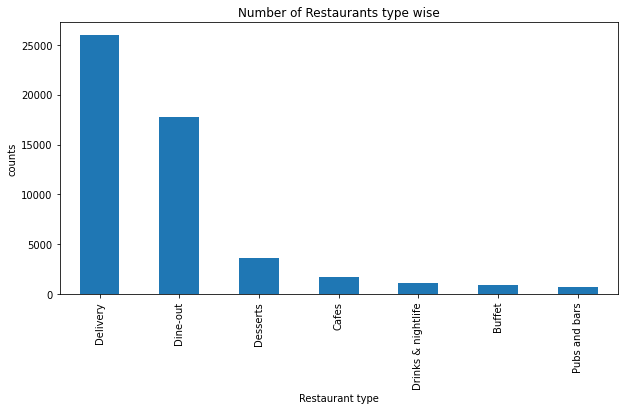

In [83]:
plt.figure(figsize=(10,5))
k =df['listed_in(type)'].value_counts()
k.plot(kind='bar')
plt.title('Number of Restaurants type wise')
plt.xlabel('Restaurant type')
plt.ylabel('counts')



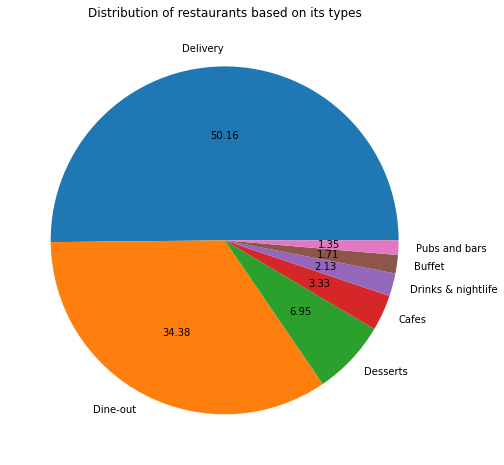

In [84]:
import matplotlib. pyplot as plt
plt.figure(figsize=(10,8))
x = df['listed_in(type)'].value_counts()[:15]
y = df['listed_in(type)'].value_counts()[:15].index
plt.pie(x, labels=y, autopct='%.2f')
plt.title('Distribution of restaurants based on its types')
plt.show()

<b> Conclusion</b> - Aound 50% of the restaurants in bangalore belongs to the delivery type of restaurants. The least type of restaurants in bangalore belongs to pubs and bars, buffet, drinks and nightlife. Also there are lot of restaurants (34%) which allows dine-out service. In total there ar 24728 restaurants that belongs to delivery type. The number of Pubs and bar is 669 whihc the minimum among all the types of restaurants

#### Pairplot

In [85]:
df2=df.copy()

In [86]:
df2['approx_cost(for two people)'].dtype

dtype('float64')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


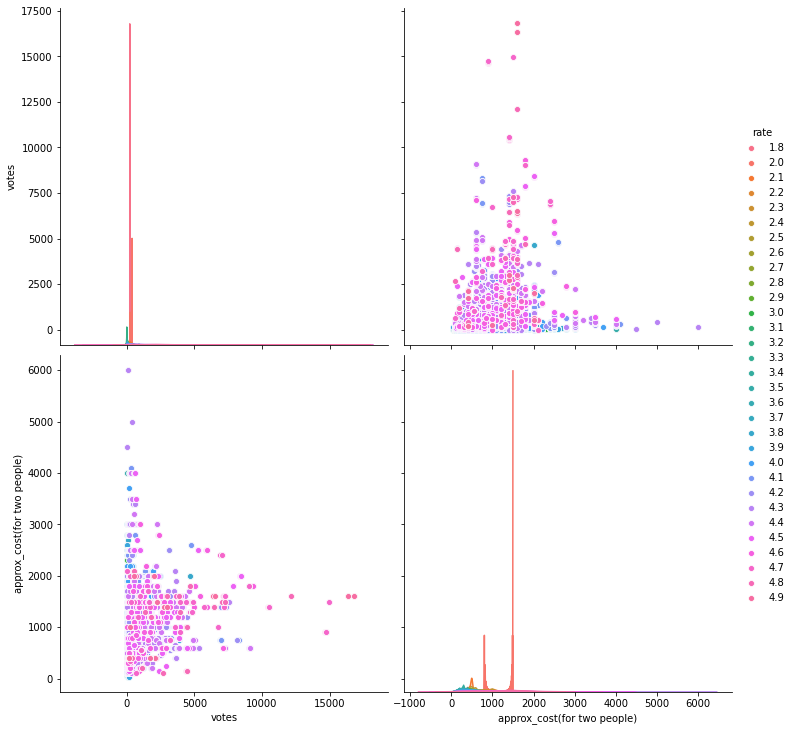

In [87]:
sns.pairplot(df,hue="rate",size=5)
plt.show()

<b>Conclusion from this pairplot</b><br>
1. In the plot of votes vs rate, most of restaurants having higher no. of votes has better ratings also
2. In the plot of approx_cost vs rate, the restaurant whose rating is high has more price.
3. In the graph of rate vs cost, rate vs votes, the data points are linearly separable

# EDA Summary

1. BTM alone has 3108 restarants which is the highest number of Restaurants in Bangalore as compared to any other location. BEL has the least Number of restaurants ie. 725. Number of restaurants in BTM comprise of 17% of total restaurants

2. The number of restaurants that takes online order is more than those which don't accepts online order. There are more 29342 restaurants that are accepting online orders and there are 20098 restaurants that are not accepting online order

3. There is a variation in ratings of restarants between 1.8 to 4.9. The average rating of restaurants is 3.7. 

4. CCD has 93 stores in bangalore which the highest number of stores for any restaurant in bangalore follwed by onesta having 85 restaurants. 

5. There are 43120 restaurants that are accepting the booking of table and 6320 restarants that are not accepting the booking of table. Majority of restaurants may be street food type restaurant as it is not allowing booking of table

6. North Indian, Chinese and South indian are the top 3 cuisines avalable in the most of restaurants.

7. Chicken is the most liked dish by the peoples of bangalore followed by Biryani and rice.

8. The average cost of restaurants for the dining is 561. Minimum cost is 40 and max cost is 4000. Overall, 87.22% of the restaurants are not allowing the booking of tables

9. Only for those restaurants whose rating is 3.7, the number of restaurants accepting online order is more than the restaurants who don't accepts the online order. For all the other restaurants (whose rating is other than 3.7), there are mpre no. of restaurants that accepts online order rather than the restaurants who don't accepts the online order.

10. Aound 50% of the restaurants in bangalore belongs to the delivery type of restaurants. The least type of restaurants in bangalore belongs to pubs and bars, buffet, drinks and nightlife. Also there are lot of restaurants (34%) which allows dine-out service. In total there ar 24728 restaurants that belongs to delivery type. The number of Pubs and bar is 669 whihc the minimum among all the types of restaurants

11. The maximum no. restaurants that allows table booking has an average rating of 4.2 . The maximum number of restaurants, which dont allows table booking has an average rating of 3.7 . Irrespective of ratings, the number of restaurants that allows booking of tables are less than the restaurants which don;t allows that.

## Checking for multicolliearity

In [88]:
#https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [89]:
k=df.copy()

In [90]:
from sklearn.preprocessing import LabelEncoder
T = LabelEncoder()                 
k['location'] = T.fit_transform(k['location'])
k['rest_type'] = T.fit_transform(k['rest_type'])
k['cuisines'] = T.fit_transform(k['cuisines'])


In [91]:
k['dish_liked'] = T.fit_transform(k['dish_liked'])

In [92]:
k['online_order'] = T.fit_transform(k['online_order'])
k['listed_in(city)'] = T.fit_transform(k['listed_in(city)'])
k['book_table'] = T.fit_transform(k['book_table'])
k['listed_in(type)'] = T.fit_transform(k['listed_in(type)'])

In [93]:
k=k.drop(['menu_item','reviews_list'],axis=1)

In [94]:
k=k.drop(['name','rate'],axis=1)

In [95]:
k.head(1)

,online_order,book_table,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),listed_in(city),dish_liked
6,0,0,8,57,27,2210,800.0,0,1,2494


In [96]:
calc_vif(k)

,variables,VIF
0,online_order,2.172145
1,book_table,1.936908
2,votes,1.399790
3,location,3.061928
4,rest_type,4.790761
5,cuisines,4.479797
6,approx_cost(for two people),4.389293
7,listed_in(type),5.981923
8,listed_in(city),4.022575
9,dish_liked,3.428151


<b>Conclusion</b> -  Hence by ananlyzing the vif values, we can conclude that  there is no multicollinearlity between any independent variables beacause the vif values are very small for each of the independent variables.

## Feature Engineering

In [97]:
df.head(2)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),dish_liked
6,Rosewood International Hotel - Bar & Restaurant,No,No,3.6,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,"Kadhai Paneer, Ghee Rice, Chicken Grill, Shawa..."
19,360 Atoms Restaurant And Cafe,Yes,No,3.1,13,Banashankari,Cafe,"Cafe, Chinese, Continental, Italian",400.0,"[('Rated 5.0', 'RATED\n Friendly staffs , nic...",[],Cafes,Banashankari,Friendly Staff


1. Total No. of cuisines available in each of the restaurant

In [98]:
df['number_of_cuisines']=df['cuisines'].str.split(',').apply(len)

2. Total number of dishes liked by the customers. It may be directly proportional to the rating

In [99]:
df['number_of_liked_dishes']=df['dish_liked'].str.split(',').apply(len)

3. Facilities offered by restaurants - there are 2 major facilities that a restaurant can proive is obline order and booking tables. so, here we are summing both of them to find the overall quality of service by the restaurant.

In [100]:
df['Facilities_offered']=k['online_order']+k['book_table']

In [101]:
df.head(2)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),dish_liked,number_of_cuisines,number_of_liked_dishes,Facilities_offered
6,Rosewood International Hotel - Bar & Restaurant,No,No,3.6,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",[],Buffet,Banashankari,"Kadhai Paneer, Ghee Rice, Chicken Grill, Shawa...",4,7,0
19,360 Atoms Restaurant And Cafe,Yes,No,3.1,13,Banashankari,Cafe,"Cafe, Chinese, Continental, Italian",400.0,"[('Rated 5.0', 'RATED\n Friendly staffs , nic...",[],Cafes,Banashankari,Friendly Staff,4,1,1


4. This function is used to convert categorical features into response coded features. It simply perform MEAN VALUE REPLACEMENT.

In [102]:
# # https://www.geeksforgeeks.org/python-creating-a-pandas-dataframe-column-based-on-a-given-condition/

key_dict = dict()
def provide_response_coded_features(groupByVal,columnName, df):
        ## distribute values group by n take mean of rate column
    mean_df = df.groupby([groupByVal]).mean()
    ## stored in dict data type.. key is column name and values in mean value of rate column.
    mean_dict =mean_df['rate'].to_dict()
    key_dict.update([ (groupByVal, mean_dict) ] )
    for k, v in mean_dict.items():
            mean_dict[k] = round(v,2)
    df[columnName] = df[groupByVal].map(mean_dict) 
    return df

In [103]:
# create response coded feature for dish_liked feature.

mean_dish_liked =provide_response_coded_features('dish_liked','mean_dish_liked',df)
mean_dish_liked[['rate','dish_liked','mean_dish_liked']][:10]

,rate,dish_liked,mean_dish_liked
6,3.6,"Kadhai Paneer, Ghee Rice, Chicken Grill, Shawa...",3.68
19,3.1,Friendly Staff,3.56
22,3.6,"Pasta, Iced Tea",3.54
24,3.7,"Waffles, Pasta, Crispy Chicken, Honey Chilli C...",3.60
25,3.2,"Waffles, Pasta, Crispy Chicken, Honey Chilli C...",3.60
26,3.8,"Masala Dosa, Idli, Filter Coffee, Medu Dosa",3.67
27,3.3,"Tandoori Maggi, Paneer Sizzler, Pasta, Pizza, ...",3.49
28,3.3,"Pasta, Iced Tea",3.54
32,3.9,"Waffles, Pasta, Crispy Chicken, Honey Chilli C...",3.60
36,2.8,"Panneer Butter Masala, Lassi, Paratha, Jeera R...",3.52


In [104]:
mean_cuisines =provide_response_coded_features('cuisines','mean_cuisines',df)
mean_cuisines[['rate','cuisines','mean_cuisines']][:10]

,rate,cuisines,mean_cuisines
6,3.6,"North Indian, South Indian, Andhra, Chinese",3.90
19,3.1,"Cafe, Chinese, Continental, Italian",3.69
22,3.6,"Cafe, Fast Food",3.39
24,3.7,Cafe,3.64
25,3.2,"Cafe, Bakery",3.82
26,3.8,"Cafe, South Indian",3.78
27,3.3,"Cafe, Fast Food, Beverages",3.69
28,3.3,"Cafe, Fast Food",3.39
32,3.9,"Bakery, Desserts",3.65
36,2.8,"North Indian, Chinese, Fast Food",3.45


In [105]:
def return_dict_mean_value(query_feature):

    result_dict=dict()

    for feature_name, values in key_dict.items():    
        if feature_name == query_feature:
            for key in values:
                result_dict.update([ (key, values[key]) ] )

                print(key + ':', values[key])
    return result_dict
return_dict_mean_value('online_order')

{}

In [1]:
dict_cuisines = return_dict_mean_value('cuisines')
dict_dish_liked = return_dict_mean_value('dish_liked')


In [107]:
df['mean_cuisines'] = df['cuisines'].map(dict_cuisines)
df['mean_dish_liked'] = df['dish_liked'].map(dict_dish_liked)


In [108]:
df[['rate','mean_dish_liked']]

,rate,mean_dish_liked
6,3.6,3.68
19,3.1,3.56
22,3.6,3.54
24,3.7,3.60
25,3.2,3.60
...,...,...
50032,3.5,3.38
50050,3.5,3.38
50135,3.5,3.50
50571,3.5,3.44


## Feature Engineering Summary
1. Mean value replacement for dish_liked - Here, first we have done response coding followed by mean value replacement for dish_liked colimn. We found its value is almost simillar to the rate column
2. Mean value replacement for cuisines - Here also, first we have done response coding followed by mean value replacement for cuisisnes column.
3. Number of cuisines available- This column contains the total number of cuisines available in each restaurants
4. Number of dish_liked -  This column contains the total number of dishes liked by the customers in each restaurants.
5. Facilities offered - If the restarant is allowing both online_order and booking_table, then we have given the facilities offered values as 2. If restarant is allowing either of the them, then we've given the values as 1. If the restarant os not allowing any of the faciilities, then we've given the value as 0.

In [109]:
df=df.drop(['name','menu_item'],axis=1)

In [110]:
df.head(2)

,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),dish_liked,number_of_cuisines,number_of_liked_dishes,Facilities_offered,mean_dish_liked,mean_cuisines
6,No,No,3.6,8,Mysore Road,Casual Dining,"North Indian, South Indian, Andhra, Chinese",800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",Buffet,Banashankari,"Kadhai Paneer, Ghee Rice, Chicken Grill, Shawa...",4,7,0,3.68,3.90
19,Yes,No,3.1,13,Banashankari,Cafe,"Cafe, Chinese, Continental, Italian",400.0,"[('Rated 5.0', 'RATED\n Friendly staffs , nic...",Cafes,Banashankari,Friendly Staff,4,1,1,3.56,3.69


## Preprocessing of Features


In [111]:
df['dish_liked'] = df['dish_liked'].str.replace(',','')
df['cuisines'] = df['cuisines'].str.replace(',','')

In [112]:
df.head(1)

,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),reviews_list,listed_in(type),listed_in(city),dish_liked,number_of_cuisines,number_of_liked_dishes,Facilities_offered,mean_dish_liked,mean_cuisines
6,No,No,3.6,8,Mysore Road,Casual Dining,North Indian South Indian Andhra Chinese,800.0,"[('Rated 5.0', 'RATED\n Awesome food ??Great ...",Buffet,Banashankari,Kadhai Paneer Ghee Rice Chicken Grill Shawarma...,4,7,0,3.68,3.9


In [113]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [114]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
import re
# tqdm is for printing the status bar
word_counter = []

from nltk.corpus import stopwords

def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub('[0-9]+', '', sentance)
        sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = ' '.join(word.lower() for word in sentance.split() if len(word)>1 and word.lower() not in stopwords.words('english'))
        sentance = re.sub(r"rated", "", sentance)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text



def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

preprocessed_reviews = filterised_text(df['reviews_list'].astype(str).values)
df['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]
                    

100%|██████████| 51717/51717 [1:59:38<00:00,  7.20it/s]


'must try chicken biryani ngot delivery ubereats promotion going regarding biryani taste albeit good biryani quantity wise extremely less consider ordering starter usually finish starter biryani alone ur ordering biryani may quantity less coz promotion nanyhow interaction staff fast delivery good food   worst restuatant went check place green glen none even bothered ask needed interested finally call take order take mins get food items pathetic service plates dirty cleanliness maintained food also worst everything half boiled inspite taking mins   honestly restaurant great potential one coolest green glen layout next lot apartments spacious interiors well covered menu nhowever always felt short staff ni tried lunch dinner nbreakfast yes maybe times nthey make delicious cheese masala dosa bread omelette poori sabji masala chai   npathetic place mosquitoes eat well food arrives page menu half things available takes lifetime serve even customers half place empty guess reason   went place 

In [115]:
y=df['rate']
df=df.drop(['rate'],axis=1)


In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## Vectorizing categorical fearures

In [117]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['online_order'].values)
print(vectorizer.get_feature_names())

X_tr_order_ohe = vectorizer.transform(X_train['online_order'].values)
X_cv_order_ohe = vectorizer.transform(X_cv['online_order'].values)
X_test_order_ohe = vectorizer.transform(X_test['online_order'].values)
print("Shape of training dataset one hot encoding & corresponding class label ",X_tr_order_ohe.shape, y_train.shape)
print("\nShape of cv dataset one hot encoding & corresponding class label ",X_cv_order_ohe.shape, y_cv.shape)
print("\nShape of test dataset one hot encoding & corresponding class label ",X_test_order_ohe.shape, y_test.shape)

['no', 'yes']
Shape of training dataset one hot encoding & corresponding class label  (23215, 2) (23215,)

Shape of cv dataset one hot encoding & corresponding class label  (11435, 2) (11435,)

Shape of test dataset one hot encoding & corresponding class label  (17067, 2) (17067,)


In [118]:
vectorizer = CountVectorizer()
vectorizer.fit(df['location'].values)
print(vectorizer.get_feature_names())

X_tr_location_ohe = vectorizer.transform(X_train['location'].values)
X_cv_location_ohe = vectorizer.transform(X_cv['location'].values)
X_test_location_ohe = vectorizer.transform(X_test['location'].values)

['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', 'airport', 'banashankari', 'banaswadi', 'bangalore', 'bannerghatta', 'basavanagudi', 'basaveshwara', 'bel', 'bellandur', 'bhima', 'block', 'bommanahalli', 'brigade', 'brookefield', 'btm', 'central', 'church', 'city', 'commercial', 'course', 'cunningham', 'cv', 'domlur', 'east', 'ejipura', 'electronic', 'frazer', 'garden', 'hbr', 'hebbal', 'hennur', 'hosur', 'hsr', 'indiranagar', 'infantry', 'itpl', 'jakkur', 'jalahalli', 'jayanagar', 'jeevan', 'jp', 'kaggadasapura', 'kalyan', 'kammanahalli', 'kanakapura', 'kengeri', 'koramangala', 'kr', 'kumaraswamy', 'langford', 'lavelle', 'layout', 'madras', 'magadi', 'main', 'majestic', 'malleshwaram', 'marathahalli', 'market', 'marks', 'mg', 'mysore', 'nagar', 'nagarbhavi', 'nagawara', 'new', 'north', 'old', 'peenya', 'puram', 'race', 'rajajinagar', 'rajarajeshwari', 'raman', 'rammurthy', 'residency', 'richmond', 'road', 'rt', 'sadashiv', 'sahakara', 'sanjay', 'sankey', 'sarjapur', 'seshadrip

In [119]:
vectorizer = CountVectorizer()
vectorizer.fit(df['book_table'].values)
print(vectorizer.get_feature_names())

X_tr_book_table_ohe = vectorizer.transform(X_train['book_table'].values)
X_cv_book_table_ohe = vectorizer.transform(X_cv['book_table'].values)
X_test_book_table_ohe = vectorizer.transform(X_test['book_table'].values)

['no', 'yes']


In [120]:
vectorizer = CountVectorizer()
vectorizer.fit(df['rest_type'].values)
print(vectorizer.get_feature_names())

X_tr_rest_type_ohe = vectorizer.transform(X_train['rest_type'].values)
X_cv_rest_type_ohe = vectorizer.transform(X_cv['rest_type'].values)
X_test_rest_type_ohe = vectorizer.transform(X_test['rest_type'].values)

['bakery', 'bar', 'beverage', 'bhojanalya', 'bites', 'cafe', 'cafee', 'casual', 'club', 'confectionery', 'court', 'delivery', 'dessert', 'dhaba', 'dining', 'fine', 'food', 'irani', 'kiosk', 'lounge', 'meat', 'mess', 'microbrewery', 'parlor', 'pop', 'pub', 'quick', 'shop', 'sweet', 'takeaway', 'truck', 'up']


In [121]:
vectorizer = CountVectorizer()
vectorizer.fit(df['dish_liked'].values)
print(vectorizer.get_feature_names())

X_tr_dish_liked_ohe = vectorizer.transform(X_train['dish_liked'].values)
X_cv_dish_liked_ohe = vectorizer.transform(X_cv['dish_liked'].values)
X_test_dish_liked_ohe = vectorizer.transform(X_test['dish_liked'].values)

['65', 'aalo', 'aam', 'aamras', 'abbabi', 'achari', 'adrak', 'afghan', 'afghani', 'aglio', 'ajwaini', 'akki', 'akuri', 'al', 'alfam', 'alfredo', 'almond', 'almonds', 'aloo', 'alpham', 'alur', 'ambience', 'ambur', 'american', 'americano', 'amritsari', 'anardana', 'ande', 'andhra', 'angara', 'anjal', 'anjeer', 'apollo', 'appam', 'apple', 'appletini', 'arabian', 'arabic', 'arrabiata', 'arrangement', 'arsalan', 'arugula', 'asparagus', 'au', 'augratin', 'avakai', 'avalanche', 'avocado', 'baati', 'babaganush', 'baby', 'babycorn', 'bacon', 'baconator', 'badam', 'badami', 'bagel', 'baguette', 'baida', 'baigan', 'baingan', 'bajji', 'baked', 'baklava', 'ball', 'balls', 'balti', 'bamboo', 'banana', 'bananas', 'bang', 'bangkok', 'bangla', 'banh', 'bannoffee', 'banoffee', 'bao', 'bar', 'barbaresca', 'barbecue', 'barbeque', 'barfi', 'barone', 'bartha', 'basa', 'basanti', 'basil', 'basket', 'basmati', 'bath', 'bati', 'batter', 'bbq', 'beans', 'beda', 'beef', 'beer', 'beetroot', 'begun', 'beijing', 'b

In [122]:
vectorizer = CountVectorizer()
vectorizer.fit(df['cuisines'].values)
print(vectorizer.get_feature_names())

X_tr_cuisines_ohe = vectorizer.transform(X_train['cuisines'].values)
X_cv_cuisines_ohe = vectorizer.transform(X_cv['cuisines'].values)
X_test_cuisines_ohe = vectorizer.transform(X_test['cuisines'].values)

['afghan', 'afghani', 'african', 'american', 'andhra', 'arabian', 'asian', 'assamese', 'australian', 'awadhi', 'bakery', 'bar', 'bbq', 'belgian', 'bengali', 'beverages', 'bihari', 'biryani', 'bohri', 'british', 'bubble', 'burger', 'burmese', 'cafe', 'cantonese', 'charcoal', 'chettinad', 'chicken', 'chinese', 'coffee', 'continental', 'cream', 'desserts', 'dogs', 'drinks', 'eastern', 'european', 'fast', 'finger', 'food', 'french', 'german', 'goan', 'greek', 'grill', 'gujarati', 'healthy', 'hot', 'hyderabadi', 'ice', 'indian', 'indonesian', 'iranian', 'italian', 'japanese', 'jewish', 'juices', 'kashmiri', 'kebab', 'kerala', 'konkan', 'korean', 'lankan', 'lebanese', 'lucknowi', 'maharashtrian', 'malaysian', 'malwani', 'mangalorean', 'meats', 'mediterranean', 'mex', 'mexican', 'middle', 'mithai', 'modern', 'momos', 'mongolian', 'mughlai', 'naga', 'nepalese', 'north', 'only', 'oriya', 'paan', 'pan', 'parsi', 'pizza', 'portuguese', 'rajasthani', 'raw', 'roast', 'rolls', 'russian', 'salad', 's

In [123]:
vectorizer = CountVectorizer()
vectorizer.fit(df['listed_in(type)'].values)
print(vectorizer.get_feature_names())


X_tr_listed_in_tp_ohe = vectorizer.transform(X_train['listed_in(type)'].values)
X_cv_listed_in_tp_ohe = vectorizer.transform(X_cv['listed_in(type)'].values)
X_test_listed_in_tp_ohe = vectorizer.transform(X_test['listed_in(type)'].values)

['and', 'bars', 'buffet', 'cafes', 'delivery', 'desserts', 'dine', 'drinks', 'nightlife', 'out', 'pubs']


In [124]:
vectorizer = CountVectorizer()
vectorizer.fit(df['listed_in(city)'].values)
print(vectorizer.get_feature_names())


X_tr_listed_in_ct_ohe = vectorizer.transform(X_train['listed_in(city)'].values)
X_cv_listed_in_ct_ohe = vectorizer.transform(X_cv['listed_in(city)'].values)
X_test_listed_in_ct_ohe = vectorizer.transform(X_test['listed_in(city)'].values)

['4th', '5th', '6th', '7th', 'airport', 'banashankari', 'bannerghatta', 'basavanagudi', 'bel', 'bellandur', 'block', 'brigade', 'brookefield', 'btm', 'church', 'city', 'electronic', 'frazer', 'hsr', 'indiranagar', 'jayanagar', 'jp', 'kalyan', 'kammanahalli', 'koramangala', 'lavelle', 'malleshwaram', 'marathahalli', 'mg', 'nagar', 'new', 'old', 'rajajinagar', 'residency', 'road', 'sarjapur', 'street', 'town', 'whitefield']


## Vectorizing Numerical Features

In [125]:
from sklearn.preprocessing import Normalizer

cost_scalar = Normalizer()
cost_scalar.fit(X_train['approx_cost(for two people)'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
cost_standardized_train = cost_scalar.transform(X_train['approx_cost(for two people)'].values.reshape(-1, 1))
cost_standardized_cv = cost_scalar.transform(X_cv['approx_cost(for two people)'].values.reshape(-1, 1))
cost_standardized_test = cost_scalar.transform(X_test['approx_cost(for two people)'].values.reshape(-1, 1))

In [126]:
number_of_cuisines_scalar = Normalizer()
number_of_cuisines_scalar.fit(X_train['number_of_cuisines'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
number_of_cuisines_standardized_train = number_of_cuisines_scalar.transform(X_train['number_of_cuisines'].values.reshape(-1, 1))
number_of_cuisines_standardized_cv = number_of_cuisines_scalar.transform(X_cv['number_of_cuisines'].values.reshape(-1, 1))
number_of_cuisines_standardized_test = number_of_cuisines_scalar.transform(X_test['number_of_cuisines'].values.reshape(-1, 1))

In [127]:
number_of_liked_dishes_scalar = Normalizer()
number_of_liked_dishes_scalar.fit(X_train['number_of_liked_dishes'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
# print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
number_of_liked_dishes_standardized_train = number_of_liked_dishes_scalar.transform(X_train['number_of_liked_dishes'].values.reshape(-1, 1))
number_of_liked_dishes_standardized_cv = number_of_liked_dishes_scalar.transform(X_cv['number_of_liked_dishes'].values.reshape(-1, 1))
number_of_liked_dishes_standardized_test = number_of_liked_dishes_scalar.transform(X_test['number_of_liked_dishes'].values.reshape(-1, 1))

In [128]:
from sklearn.preprocessing import Normalizer

votes_scalar = Normalizer()
votes_scalar.fit(X_train['votes'].values.reshape(-1,1)) 

votes_standardized_train = votes_scalar.transform(X_train['votes'].values.reshape(-1, 1))
votes_standardized_cv = votes_scalar.transform(X_cv['votes'].values.reshape(-1, 1))
votes_standardized_test = votes_scalar.transform(X_test['votes'].values.reshape(-1, 1))

In [129]:
from sklearn.preprocessing import Normalizer

Facilities_offered_scalar = Normalizer()
Facilities_offered_scalar.fit(X_train['Facilities_offered'].values.reshape(-1,1))

Facilities_offered_standardized_train = Facilities_offered_scalar.transform(X_train['Facilities_offered'].values.reshape(-1, 1))
Facilities_offered_standardized_cv = Facilities_offered_scalar.transform(X_cv['Facilities_offered'].values.reshape(-1, 1))
Facilities_offered_standardized_test = Facilities_offered_scalar.transform(X_test['Facilities_offered'].values.reshape(-1, 1))

In [130]:
from sklearn.preprocessing import Normalizer

Facilities_offered_scalar = Normalizer()
Facilities_offered_scalar.fit(X_train['Facilities_offered'].values.reshape(-1,1))

Facilities_offered_standardized_train = Facilities_offered_scalar.transform(X_train['Facilities_offered'].values.reshape(-1, 1))
Facilities_offered_standardized_cv = Facilities_offered_scalar.transform(X_cv['Facilities_offered'].values.reshape(-1, 1))
Facilities_offered_standardized_test = Facilities_offered_scalar.transform(X_test['Facilities_offered'].values.reshape(-1, 1))

In [131]:
mean_cuisines_scalar = Normalizer()
mean_cuisines_scalar.fit(X_train['mean_cuisines'].values.reshape(-1,1)) 

mean_cuisines_standardized_train = mean_cuisines_scalar.transform(X_train['mean_cuisines'].values.reshape(-1, 1))
mean_of_cuisines_standardized_cv = mean_cuisines_scalar.transform(X_cv['mean_cuisines'].values.reshape(-1, 1))
mean_of_cuisines_standardized_test = mean_cuisines_scalar.transform(X_test['mean_cuisines'].values.reshape(-1, 1))

In [132]:
dish_liked_scalar = Normalizer()
dish_liked_scalar.fit(X_train['mean_dish_liked'].values.reshape(-1,1))
dish_liked_standardized_train = dish_liked_scalar.transform(X_train['mean_dish_liked'].values.reshape(-1, 1))
dish_liked_standardized_cv = dish_liked_scalar.transform(X_cv['mean_dish_liked'].values.reshape(-1, 1))
dish_liked_standardized_test = dish_liked_scalar.transform(X_test['mean_dish_liked'].values.reshape(-1, 1))

## Vectorizing Text Features

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_reviews'].values)


X_tr_preprocessed_reviews_tfidf = vectorizer.transform(X_train['preprocessed_reviews'].values)
X_cv_preprocessed_reviews_tfidf = vectorizer.transform(X_cv['preprocessed_reviews'].values)
X_test_preprocessed_reviews_tfidf = vectorizer.transform(X_test['preprocessed_reviews'].values)

In [134]:
X_tr_total =hstack((X_tr_preprocessed_reviews_tfidf,dish_liked_standardized_train, mean_cuisines_standardized_train,X_tr_order_ohe,X_tr_location_ohe,X_tr_book_table_ohe,X_tr_rest_type_ohe,X_tr_dish_liked_ohe,X_tr_cuisines_ohe,X_tr_listed_in_tp_ohe,X_tr_listed_in_ct_ohe,cost_standardized_train,number_of_liked_dishes_standardized_train)).tocsr()
X_test_total = hstack((X_test_preprocessed_reviews_tfidf,dish_liked_standardized_test, mean_of_cuisines_standardized_test,X_test_order_ohe,X_test_location_ohe,X_test_book_table_ohe,X_test_rest_type_ohe,X_test_dish_liked_ohe,X_test_cuisines_ohe,X_test_listed_in_tp_ohe,X_test_listed_in_ct_ohe,cost_standardized_test,number_of_liked_dishes_standardized_test)).tocsr()

In [135]:
import warnings
warnings.filterwarnings('ignore')

## Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor()
parameters = {'n_estimators': [1, 5, 10, 50, 100], 'max_depth': [5, 10, 20, 75, 100]} 
mdl = RandomizedSearchCV(rf, param_distributions =parameters, cv=10)
mdl.fit(X_tr_total,y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [ ]:
print(mdl.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=75, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


## Applying Random Forest Algorithm

In [ ]:
rfm= RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1)
rfm.fit(X_tr_total,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_lr = rfm.predict(X_test_total)
mean_squared_error(y_test, y_pred_lr)

0.027927709527412244

## Hyperparameter tuning for Decsion tree

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
dt1 = DecisionTreeRegressor()
parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10, 20, 45, 75, 100]}
mdl = RandomizedSearchCV(dt1, parameters)
mdl.fit(X_tr_total,y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid

In [ ]:
mdl.best_params_

{'max_depth': 50, 'min_samples_split': 100}

In [ ]:
mdl.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=100,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

## Applying Descision tree regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
mdl= DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=100,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
mdl.fit(X_tr_total,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=100,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_lr = mdl.predict(X_test_total)
mean_squared_error(y_test, y_pred_lr)

0.06577735390392918

## Hyperparameter tuning for xgboost

In [ ]:
import xgboost as xgb
model_d = xgb.XGBRegressor()
param_grid = {"n_estimators":[25, 50, 100, 200, 250, 500], "max_depth": [3, 5, 7, 9, 11, 13]}
d = RandomizedSearchCV(model_d, param_distributions = param_grid, n_iter=10, cv=10, return_train_score=True)
d.fit(X_tr_total, y_train)
print(d.best_estimator_)

[20:57:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## Applying xgboost

In [ ]:
from xgboost.sklearn import XGBRegressor
c=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
c.fit(X_tr_total,y_train)
y_pred_lr = c.predict(X_test_total)
mean_squared_error(y_test, y_pred_lr)

[15:52:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.038084723971161166

## Hyperparameter tuning for Linear regression

In [ ]:
 from sklearn.linear_model import SGDRegressor
model_d = SGDRegressor(loss='squared_loss')
param_grid = {"alpha":[0.001, 0.01,0.1,1,10,100,1000]}
d = RandomizedSearchCV(model_d, param_distributions = param_grid, n_iter=10, cv=10, return_train_score=True)
d.fit(X_tr_total, y_train)
print(d.best_estimator_)

SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


## Applying linear regression

In [ ]:
from sklearn.linear_model import SGDRegressor
x = SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
x.fit(X_tr_total, y_train)

SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_lr = x.predict(X_test_total)
mean_squared_error(y_test, y_pred_lr)

0.08059014915125161

## Deep Learning MODELS

In [267]:
X=k.copy()
Y=y
x_train, x_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.33, shuffle= True)

In [155]:
import keras
num_classes = 10

input_shape = (10,)

y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.reshape(34650, 10,1)
x_test = x_test.reshape(17067, 10,1)

### CNN-LSTM model

In [217]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D,Dropout
from keras.models import Model
#k = Dropout(0.5)(pool1)

input_layer = Input(shape=(10, 1))
conv2 = Conv1D(filters=64,
               kernel_size=3,
               strides=1,
               activation='relu')(input_layer)
dropout1 = Dropout(0.25)(conv2)
pool1 = MaxPooling1D(pool_size=1)(dropout1)
dropout1 = Dropout(0.5)(pool1)
lstm1 = LSTM(64,return_sequences=True)(dropout1)
conv3 = Conv1D(filters=128,
               kernel_size=8,
               strides=1,
               activation='relu')(lstm1)
dropout2 = Dropout(0.25)(conv3)
lstm2 = LSTM(128,return_sequences=False)(dropout2)
output_layer = Dense(1, activation='sigmoid')(lstm2)
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 10, 1)             0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 8, 64)             256       
_________________________________________________________________
dropout_61 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 8, 64)             33024     
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 1, 128)            656

In [255]:
model.compile(loss='mse',optimizer='adam')
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test), verbose=1)

Train on 34650 samples, validate on 17067 samples
Epoch 1/10
34650/34650 [==============================] - 10s 287us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 2/10
34650/34650 [==============================] - 9s 252us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 3/10
34650/34650 [==============================] - 9s 252us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 4/10
34650/34650 [==============================] - 9s 253us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 5/10
34650/34650 [==============================] - 9s 251us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 6/10
34650/34650 [==============================] - 9s 253us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 7/10
34650/34650 [==============================] - 9s 251us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 8/10
34650/34650 [==============================] - 9s 254us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 9/10
34650/34650 [==============================] - 9s 258us/step - loss: 7.2646 - val_loss: 7.

In [256]:
score = model.evaluate(x_test, y_test)
score

17067/17067 [==============================] - 1s 76us/step


7.2829501636838385

In [260]:
model.save_weights("model_1_weights.h5")

### CNN Model

In [269]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D,Dropout, GlobalMaxPool1D
input_layer = Input(shape=(10, 1))
conv2 = Conv1D(filters=64,
               kernel_size=3,
               strides=1,
               activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=1)(conv2)
drop1 = Dropout(0.5)(pool1)
pool2 = MaxPooling1D(pool_size=1)(drop1)
conv3 = Conv1D(filters=64,
               kernel_size=3,
               strides=1,
               activation='relu')(pool2)
drop2 = Dropout(0.5)(conv3)
conv4 = Conv1D(filters=64,
               kernel_size=3,
               strides=1,
               activation='relu')(drop2)
pool3 = MaxPooling1D(pool_size=1)(conv4)
conv5 = Conv1D(filters=64,
               kernel_size=3,
               strides=1,
               activation='relu')(pool3)
x = GlobalMaxPool1D()(conv5) 
output_layer = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs=input_layer, outputs=output_layer)

model_2.compile(loss='mse',optimizer='adam')
model_2.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test), verbose=1)

Train on 34650 samples, validate on 17067 samples
Epoch 1/10
34650/34650 [==============================] - 4s 103us/step - loss: 7.2887 - val_loss: 7.2830
Epoch 2/10
34650/34650 [==============================] - 3s 96us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 3/10
34650/34650 [==============================] - 3s 95us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 4/10
34650/34650 [==============================] - 3s 97us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 5/10
34650/34650 [==============================] - 3s 96us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 6/10
34650/34650 [==============================] - 3s 96us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 7/10
34650/34650 [==============================] - 3s 96us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 8/10
34650/34650 [==============================] - 3s 96us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 9/10
34650/34650 [==============================] - 3s 96us/step - loss: 7.2646 - val_loss: 7.2830
Epoc

In [270]:
model_2.evaluate(x_train,y_train)

34650/34650 [==============================] - 1s 38us/step


7.264551804750341

In [271]:
model_2.save_weights('model_2_weights.h5')

### LSTM Model

In [272]:
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D,Dropout, GlobalMaxPool1D
input_layer = Input(shape=(10, 1))
lstm1 = LSTM(64,return_sequences=True)(input_layer)
pool1 = MaxPooling1D(pool_size=1)(lstm1)
drop1 = Dropout(0.5)(pool1)
pool2 = MaxPooling1D(pool_size=1)(drop1)
lstm2 = LSTM(128,return_sequences=True)(pool2)
drop2 = Dropout(0.5)(lstm2)
lstm3 = LSTM(64,return_sequences=True)(drop2)
pool3 = MaxPooling1D(pool_size=1)(lstm3)
lstm4 = LSTM(64,return_sequences=True)(pool3)
x = GlobalMaxPool1D()(lstm4)
output_layer = Dense(1, activation='sigmoid')(x)
model_3 = Model(inputs=input_layer, outputs=output_layer)

model_3.compile(loss='mse',optimizer='adam')
model_3.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_test, y_test), verbose=1)

Train on 34650 samples, validate on 17067 samples
Epoch 1/10
34650/34650 [==============================] - 31s 901us/step - loss: 7.4128 - val_loss: 7.2932
Epoch 2/10
34650/34650 [==============================] - 30s 857us/step - loss: 7.2707 - val_loss: 7.2865
Epoch 3/10
34650/34650 [==============================] - 30s 856us/step - loss: 7.2665 - val_loss: 7.2836
Epoch 4/10
34650/34650 [==============================] - 29s 850us/step - loss: 7.2650 - val_loss: 7.2831
Epoch 5/10
34650/34650 [==============================] - 29s 846us/step - loss: 7.2647 - val_loss: 7.2830
Epoch 6/10
34650/34650 [==============================] - 29s 848us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 7/10
34650/34650 [==============================] - 30s 865us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 8/10
34650/34650 [==============================] - 29s 851us/step - loss: 7.2646 - val_loss: 7.2830
Epoch 9/10
34650/34650 [==============================] - 29s 847us/step - loss: 7.2646 - val_

In [273]:
model_3.evaluate(x_test,y_test)

17067/17067 [==============================] - 4s 256us/step


7.282953401102768

In [ ]:
model_3.save_weights('model_3_weights.h5')

# Conclusion

In [275]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ["Model",'Mean Squared Loss']
ptable.add_row(["Random forest Regressor","0.02"])
ptable.add_row(["Decision tree Regressor","0.06"])
ptable.add_row(["CNN-LSTM","0.07"])
ptable.add_row(["CNN Model","0.07"])
ptable.add_row(["CNN-LSTM","0.07"])
ptable.add_row(["XGboost Regressor","0.03"])
ptable.add_row(["Linear Regressor","0.08"])
print(ptable)

+-------------------------+-------------------+
|          Model          | Mean Squared Loss |
+-------------------------+-------------------+
| Random forest Regressor |        0.02       |
| Decision tree Regressor |        0.06       |
|         CNN-LSTM        |        0.07       |
|        CNN Model        |        0.07       |
|         CNN-LSTM        |        0.07       |
|    XGboost Regressor    |        0.03       |
|     Linear Regressor    |        0.08       |
+-------------------------+-------------------+


#### Random Forest Regressor Model is giving the Best MSE Value of 0.02